# DATASCI W261, Machine Learning at Scale
--------
#### Assignement:  week \#9
#### Shih Yu Chang
### Due: 2016-11-15, 8AM PST

# HW 9.0: Short answer questions

## What is PageRank and what is it used for in the context of web search?

PageRank is an algorithm used by Google Search to rank websites in their search engine results. PageRank was named after Larry Page, one of the founders of Google. PageRank is a way of measuring the importance of website pages. According to Google: PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites. It is not the only algorithm used by Google to order search engine results, but it is the first algorithm that was used by the company, and it is the best-known.

Because it identifies popular pages, PageRank has several applications in web search.

* PageRank can be used to change the priority with which web sites are crawled.
* PageRank can be used to provide data compression for websites, as popular sites that often come up in search results will require less bits in order to retrieve from disk or transfer over the network.
* PageRank can be used to allow popular pages arrive first in general search results without additional sorting at query time.


## What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the steady state distribution?



First, we represent the process of visiting pages as a Markov process. To do this, we suggest a random surfer model, wherein a web surfer has some probability of choosing one of the outgoing links on the page. To achieve this, each edge in the webgraph is given a weight that is proportional to the total number of outgoing edges from the source node. We define the weight of the edge as $\large\frac{1}{e_o}$, where $e_o$ is the number of outgoing edges for a given node. The first problem in the webgraph is that some webpages are dangling nodes (nodes with no outgoing edges), as they will not re-distribute their links. In order to solve this problem, we enforce such node to transite to any other node in the webgraph with uniform probability. This results in these sink nodes being given edges with weight $\large\frac{1}{n}$, where $n$ is the number of nodes in the web graph.

The second problem in the webgraph is the large number of zero probabilities, making it difficult to prove the existence of a steady state distribution. To address such issue, we introduce 
a "teleportation" factor that re-scales the webgraph by a damping factor $d$. We then recapture the $(1 - d)$ mass lost by the scaling and redistribute it to the $n$ nodes of the web graph, thus giving each node $\large\frac{1-d}{n}$ and eliminate all zeroes in the matrix. Such matrix is a Markov matrix since the entries will be strictly positive ([Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem)) and mode details about this matrix can be found at [Google matrix](https://en.wikipedia.org/wiki/Google_matrix).


## OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

One method to insure irreducible is by requiring that nodes not reachable from topic-specific nodes be removed out from the network, this is hard to implement for parallel computing since it is not easy to dentify the unreachable nodes. On the other hand, one may define a non-uniform damping factor such that all nodes will be participating in the PageRank, but the topic-s[ecific nodes will be weighted improperly according to the relative frequency in the population.



In [1]:
from __future__ import division
import os
%matplotlib inline
import matplotlib
%matplotlib inline


from collections import defaultdict, OrderedDict
from datetime import datetime
import functools
from IPython.display import display
import json
import math

import networkx
import numpy
import os
import pandas
import subprocess
import sys
matplotlib.style.use('ggplot')

%reload_ext autoreload
%autoreload 2

/home/cloudera/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# HW 9.1: MRJob implementation of basic PageRank

## HW 9.1 Implementation

In [2]:
%%writefile PageRank_Iteration.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRank_Iteration(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRank_Iteration, self).configure_options()        
        self.add_passthrough_option(
            '--i', dest='init', default='0', type='int',
            help='i: run initialization iteration (default 0)')    

    # mapper initialization
    def mapper_job_init(self, _, line):        
        # parse line
        node_id, adj_list = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'adj_list = %s' %adj_list
        exec cmd
        # initialize node struct        
        node = {'a':adj_list.keys(), 'M':0}
        rankMass = 1.0/len(adj_list)
        # emit node
        yield node_id, node
        # emit pageRank mass        
        for m in node['a']:
            yield m, rankMass
          
    # mapper for iteration 
    def mapper_job_iter(self, _, line):             
        # parse line
        node_id, node = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # distribute rank mass  
        n_adj = len(node['a'])
        if n_adj > 0:
            rankMass = 1.0*node['M'] / n_adj
            # emit pageRank mass        
            for m in node['a']:
                yield m, rankMass
        else:
            # track dangling mass with counter
            self.increment_counter('dangling_mass', 'mass', int(node['M']*1e10))
        # reset pageRank and emit node
        node['M'] = 0
        yield node_id, node
    
    def debug(self):
        de = 'bug'
                
    # Combiner 
    def combiner(self, node_id, value):             
        rankMass, node = 0.0, None        
        # loop through all arrivals
        for v in value:            
            if isinstance(v, float):
                rankMass += v                
            else:
                node = v            
        # emit accumulative mass for node       
        if node:
            node['M'] += rankMass
            yield node_id, node
        else:
            yield node_id, rankMass
    
    # reducer for initialization pass --> need to handle dangling nodes
    def reducer_job_init(self, node_id, value):      
        # increase counter for node count
        self.increment_counter('node_count', 'nodes', 1)
        rankMass, node = 0.0, None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, float):
                rankMass += v         
            else:
                node = v
        # handle dangling node, create node struct and add missing mass
        if not node:            
            node = {'a':[], 'M':rankMass}            
            self.increment_counter('dangling_mass', 'mass', int(1e10))
        else:
            node['M'] += rankMass            
        # emit for next iteration
        yield node_id, node
        
    # reducer for rank pass 
    def reducer_job_iter(self, node_id, value):              
        rankMass, node = 0.0, None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, float):
                rankMass += v         
            else:
                node = v
        # update pageRank
        node['M'] += rankMass            
        # emit for next iteration
        yield node_id, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper_job_init if self.options.init else self.mapper_job_iter                       
                       , combiner=self.combiner                       
                       , reducer=self.reducer_job_init if self.options.init else self.reducer_job_iter
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRank_Iteration.run()

Overwriting PageRank_Iteration.py


In [11]:
##### unit test #####
!python PageRank_Iteration.py PageRank-test.txt --i 1 -r 'hadoop' --output-dir 'hdfs:///user/shihyu/out'
#!cat iter1.t

No configs found; falling back on auto-configuration
Creating temp directory /tmp/PageRank_Iteration.cloudera.20161031.055829.847914
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/PageRank_Iteration.cloudera.20161031.055829.847914/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 1...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob1858597524718744289.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  Caught exception 
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1281)
	at java.lang.Thread.jo

In [12]:
%%writefile PageRankDist.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankDist(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankDist, self).configure_options()        
        self.add_passthrough_option(
            '--s', dest='size', default=0, type='int',
            help='size: node number (default 0)')    
        self.add_passthrough_option(
            '--j', dest='jump_factor', default=0.15, type='float',
            help='jump: jump factor (default 0.15)') 
        self.add_passthrough_option(
            '--n', dest='norm', default=0, type='int',
            help='norm: normalize pageRank (default 0)') 
        self.add_passthrough_option(
            '--m', dest='m', default=0, type='float',
            help='m: rank mass  (default 0)') 
    
    def mapper_init(self):
        self.damping = 1 - self.options.jump_factor        
        self.p_dangling = self.options.m / self.options.size        
    
    # needed after initialization, after node number becomes available
    def mapper_norm(self, _, line):        
        # parse line
        node_id, node = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank      
        node['M'] = ((self.p_dangling + node['M'])*self.damping+self.options.jump_factor) / self.options.size
        yield node_id, node
            
    def mapper(self, _, line):             
        # parse line
        node_id, node = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank      
        node['M'] = (self.p_dangling + node['M']) * self.damping + self.options.jump_factor
        yield node_id, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',           
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper_norm if self.options.norm else self.mapper                       
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankDist.run()


Overwriting PageRankDist.py


In [13]:
%%writefile PageRankSort.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankSort(MRJob):
    #DEFAULT_PROTOCOL = 'json'   
    
    def configure_options(self):
        super(PageRankSort, self).configure_options()        
        self.add_passthrough_option(
            '--s', dest='size', default=0, type='int',
            help='size: node number (default 0)')
        self.add_passthrough_option(
            '--n', dest='top', default=100, type='int',
            help='size: node number (default 100)')
    
    def mapper(self, _, line):        
        # parse line
        node_id, node = line.strip().split('\t', 1)
        cmd = 'node = %s' %node
        exec cmd        
        yield node['M'], node_id.strip('"')
    
    def reducer_init(self):        
        self.i = 0
        self.total = 0
    
    def reducer(self, pageRank, node_id): 
        for n in node_id:
            if self.i < self.options.top:
                self.i += 1
                self.total += pageRank
                yield n, pageRank/self.options.size
            
    def reducer_final(self):
        yield 'total mass: ', self.total/self.options.size

    def steps(self):
        jc = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1nr',
            'mapreduce.job.maps': '2', 
            'mapreduce.job.reduces': '1',  # must be 1 for sorting
        }
        return [MRStep(mapper=self.mapper, reducer_init=self.reducer_init, 
                       reducer=self.reducer, reducer_final=self.reducer_final
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankSort.run()


Overwriting PageRankSort.py


In [14]:
%%writefile PageRankJoin.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankJoin(MRJob):
    #DEFAULT_PROTOCOL = 'json'   
    
    def mapper_init(self):
        self.topRanks = {}
        # read rand list, prepare for mapper in-memory join        
        cat = Popen(['cat', 'part-00000'], stdout=PIPE)
        for line in cat.stdout:
            node_id, rank = line.strip().split('\t')
            self.topRanks[node_id.strip('"')] = rank
    
    def mapper(self, _, line):        
        # parse line
        name, node_id, d_in, d_out = line.strip().split('\t')
        if node_id in self.topRanks:                        
            yield float(self.topRanks[node_id]), '%s - %s' %(node_id, name)
    
    def reducer(self, key, value):
        for v in value:
            yield key, v
    

    def steps(self):
        jc = {            
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1nr',
            'mapreduce.job.maps': '2', 
            'mapreduce.job.reduces': '1',  # must be 1 for sorting            
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankJoin.run()



Overwriting PageRankJoin.py


In [15]:
%%writefile helper.py
#!/usr/bin/python

import requests

def getCounter(groupName, counterName, host = 'localhost'):
    # get jobs        
    getJobs = 'http://%s:19888/ws/v1/history/mapreduce/jobs' %host
    jobs = requests.get(getJobs).json()['jobs']['job'] 
    # get counters
    time_job = max([job['finishTime'] for job in jobs])
    ID = [job['id'] for job in jobs if job['finishTime'] == time_job][0]
    getCounters = 'http://%s:19888/ws/v1/history/mapreduce/jobs/%s/counters' %(host, ID)
    counterGroups = requests.get(getCounters).json()['jobCounters']['counterGroup']
    # loop through to counters to return value
    counters = [g['counter'] for g in counterGroups if g['counterGroupName']==groupName][0]
    totalValues = [c['totalCounterValue'] for c in counters if c['name']==counterName]
    return totalValues[0] if len(totalValues)==1 else None

def getCounters(groupName, host = 'localhost'):
    # get jobs        
    getJobs = 'http://%s:19888/ws/v1/history/mapreduce/jobs' %host
    jobs = requests.get(getJobs).json()['jobs']['job'] 
    # get counters
    time_job = max([job['finishTime'] for job in jobs])
    ID = [job['id'] for job in jobs if job['finishTime'] == time_job][0]
    getCounters = 'http://%s:19888/ws/v1/history/mapreduce/jobs/%s/counters' %(host, ID)
    counterGroups = requests.get(getCounters).json()['jobCounters']['counterGroup']
    # loop through to counters to return value
    counters = [g['counter'] for g in counterGroups if g['counterGroupName']==groupName]    
    return {c['name']:c['totalCounterValue'] for c in counters[0]} if len(counters)==1 else []
    

Overwriting helper.py


In [16]:
%%writefile RunPageRank.py
#!/usr/bin/python

from PageRank_Iteration import PageRank_Iteration
from PageRankDist import PageRankDist
from PageRankSort import PageRankSort
from PageRankJoin import PageRankJoin
from helper import getCounter
from subprocess import call, check_output
from time import time
import sys, getopt, datetime, os

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "g:j:i:d:s:")
    except getopt.GetoptError:
        print 'Wrong arguments format'
        sys.exit(2)
    if len(opts) != 5:
        print 'Wrong arguments number'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-g':
            graph = arg
        elif opt == '-j':
            jump = arg
        elif opt == '-i':            
            n_iter = arg
        elif opt == '-d':
            index = arg
        elif opt == '-s':
            n_node = arg
        
start = time()
FNULL = open(os.devnull, 'w')
n_iter = int(n_iter)
doJoin = index!='NULL'
doInit = n_node=='0'
host = 'localhost'

print '%s: %s PageRanking on \'%s\' for %d iterations with damping factor %.2f ...' %(str(datetime.datetime.now()),
          'start' if doInit else 'continue', graph[graph.rfind('/')+1:], n_iter, 1-float(jump))

if doInit:
    # clear directory
    print str(datetime.datetime.now()) + ': clean directory ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/out'], stdout=FNULL)
    
    # creat initialization job    
    init_job = PageRank_Iteration(args=[graph, '--i', '1', '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])

    # run initialization job
    print str(datetime.datetime.now()) + ': run iteration 1 ...'
    with init_job.make_runner() as runner:    
        runner.run()

    # checking counters
    n_node = getCounter('node_count', 'nodes', host)
    n_dangling = getCounter('dangling_mass', 'mass', host)/1e10
    print '%s: initialization complete: total %d nodes with %d dangling!' %(str(datetime.datetime.now()), n_node, n_dangling)

    # run redistribution job
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])
    dist_job = PageRankDist(args=['hdfs:///user/shihyu/in/part*', '--s', str(n_node), '--j', jump, '--n', '0', 
                                '--m', str(n_dangling), '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])
    print str(datetime.datetime.now()) + ': loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()

# move results for next iteration
call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])

# create iteration job
iter_job = PageRank_Iteration(args=['hdfs:///user/shihyu/in/part*', '--i', '0', 
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])
# run pageRank iteratively
i = 2 if doInit else 1
while(1):    
    print str(datetime.datetime.now()) + ': run iteration %d ...' %i
    with iter_job.make_runner() as runner:        
        runner.run()
    
    # check counter for loss mass
    mass_loss = getCounter('dangling_mass', 'mass', host)/1e10
    
    # move results for next iteration
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])
        
    # run redistribution job
    dist_job = PageRankDist(args=['hdfs:///user/shihyu/in/part*', '--s', str(n_node), '--j', jump, '--n', '0', 
                                '--m', str(mass_loss), '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])
    print str(datetime.datetime.now()) + ': loss mass %.4f ...' %mass_loss
    with dist_job.make_runner() as runner:    
        runner.run()
    
    if i == n_iter:
        break
    
    # if more iteration needed
    i += 1    
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'], stdout=FNULL)

# run sort job
print str(datetime.datetime.now()) + ': sort with rank ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/rank'], stdout=FNULL)
sort_job = PageRankSort(args=['hdfs:///user/shihyu/out/part*', '--s', str(n_node), '--n', '100',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/rank'])
with sort_job.make_runner() as runner:    
    runner.run()
    
# run join job
if doJoin:
    print str(datetime.datetime.now()) + ': join with index ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/join'], stdout=FNULL)
    join_job = PageRankJoin(args=[index, '-r', 'hadoop', '--file', 'hdfs:///user/shihyu/rank/part-00000', 
                                  '--output-dir', 'hdfs:///user/shihyu/join'])
    with join_job.make_runner() as runner:
        runner.run()

print "%s: PageRank job completes in %.2f secs!\n" %(str(datetime.datetime.now()), (time()-start))
call(['hdfs', 'dfs', '-cat', '/user/shihyu/join/p*' if doJoin else '/user/shihyu/rank/p*'])

Overwriting RunPageRank.py


In [18]:
!hdfs dfs -mkdir -p /user/shihyu
!hdfs dfs -put PageRank-test.txt /user/shihyu # 
!hdfs dfs -put PageRank-test_indexed.txt /user/shihyu 

put: `/user/shihyu/PageRank-test.txt': File exists
put: `/user/shihyu/PageRank-test_indexed.txt': File exists


In [14]:
##### unit test #####
!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 0.15 -i 5 -d 'NULL' -s '0'

2016-10-29 10:18:49.656087: start PageRanking on 'PageRank-test.txt' for 5 iterations with damping factor 0.85 ...
2016-10-29 10:18:49.656184: clean directory ...
2016-10-29 10:18:56.268776: run iteration 1 ...
2016-10-29 10:19:46.556485: initialization complete: total 11 nodes with 1 dangling!
2016-10-29 10:19:49.566088: loss mass ...
2016-10-29 10:20:38.249698: run iteration 2 ...
2016-10-29 10:21:31.100684: loss mass 0.6523 ...
2016-10-29 10:22:13.461799: run iteration 3 ...
2016-10-29 10:23:04.563762: loss mass 0.4174 ...
2016-10-29 10:23:45.351284: run iteration 4 ...
2016-10-29 10:24:38.856519: loss mass 0.7042 ...
2016-10-29 10:25:22.453807: run iteration 5 ...
2016-10-29 10:26:18.827509: loss mass 0.4136 ...
2016-10-29 10:26:57.513299: sort with rank ...
2016-10-29 10:27:39.611800: PageRank job completes in 529.96 secs!

"B"	0.41918431938544826
"C"	0.28315371579980053
"E"	0.09396022931969215
"F"	0.041159633622549346
"D"	0.041159633622549346
"A"	0.03867493638987295
"K"	0.0165415

In [19]:
##### unit test #####
!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 0.15 -i 2 -d 'NULL' -s '0'

2016-10-30 23:01:09.895269: start PageRanking on 'PageRank-test.txt' for 2 iterations with damping factor 0.85 ...
2016-10-30 23:01:09.895340: clean directory ...
rm: `/user/shihyu/in': No such file or directory
2016-10-30 23:01:16.793547: run iteration 1 ...
No handlers could be found for logger "mrjob.hadoop"
2016-10-30 23:02:24.445533: initialization complete: total 11 nodes with 1 dangling!
2016-10-30 23:02:27.773070: loss mass ...
2016-10-30 23:03:25.228096: run iteration 2 ...
2016-10-30 23:04:51.659118: loss mass 0.6523 ...
2016-10-30 23:05:52.601844: sort with rank ...
rm: `/user/shihyu/rank': No such file or directory
2016-10-30 23:07:01.214555: PageRank job completes in 351.32 secs!

"C"	0.2875607312792286
"B"	0.26069089656848482
"F"	0.11164819684396692
"D"	0.11164819684396692
"E"	0.099413348359118456
"A"	0.037946406210358122
"K"	0.018218444777851239
"I"	0.018218444777851239
"G"	0.018218444777851239
"J"	0.018218444777851239
"H"	0.018218444777851239
"total mass: "	0.9999999999

### PageRankTestMine mimic wiki folder indices file format, since PageRank-test_indexed.txt format is not indices.
####  BBB     B       1       1 
####  CCC     C       1       1 
####  DDD     D       1       1 
####  EEE     E       1       1 
####  FFF     F       1       1 
####  GGG     G       1       1 
####  HHH     H       1       1 
####  III     I       1       1 
#### JJJ     J       1       1 
#### KKK     K       1       1 

In [10]:
##### unit test #####
!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 0.15 -i 2 \
-d 'hdfs:///user/shihyu/PageRankTestMine.txt' -s '0'
!hdfs dfs -cat /user/shihyu/join/p* > HW_9_1_test_join
!head -3 HW_9_1_test_join 

2016-10-29 12:38:12.770999: start PageRanking on 'PageRank-test.txt' for 2 iterations with damping factor 0.85 ...
2016-10-29 12:38:12.771073: clean directory ...
rm: `/user/shihyu/in': No such file or directory
2016-10-29 12:38:23.335957: run iteration 1 ...
2016-10-29 12:39:34.029228: initialization complete: total 11 nodes with 1 dangling!
2016-10-29 12:39:38.067543: loss mass ...
2016-10-29 12:40:31.992122: run iteration 2 ...
No handlers could be found for logger "mrjob.hadoop"
2016-10-29 12:41:40.486496: loss mass 0.6523 ...
2016-10-29 12:42:26.402775: sort with rank ...
2016-10-29 12:43:26.993978: join with index ...
2016-10-29 12:44:23.620271: PageRank job completes in 370.85 secs!

0.2875607312792286	"C - CCC"
0.2606908965684848	"B - BBB"
0.11164819684396692	"F - FFF"
0.11164819684396692	"D - DDD"
0.09941334835911846	"E - EEE"
0.01821844477785124	"G - GGG"
0.01821844477785124	"K - KKK"
0.01821844477785124	"J - JJJ"
0.01821844477785124	"I - III"
0.01821844477785124	"H - HHH"
0.

In [35]:
!head -4 HW_9_1_test_join 

0.2875607312792286	"C - CCC"
0.2606908965684848	"B - BBB"
0.11164819684396692	"F - FFF"
0.11164819684396692	"D - DDD"


"E"	0.29850770097619833
"B"	0.2875607312792286
"C"	0.1014622464307438
"A"	0.06862133733983472
"F"	0.057674367642865
"D"	0.057674367642865
"J"	0.03578042824892562
"H"	0.03578042824892562
"K"	0.03578042824892562
"I"	0.03578042824892562
"G"	0.03578042824892562
"total mass: "	1.0504028925563633

In [81]:
!hdfs dfs -mkdir -p /user/shihyu
!hdfs dfs -put all-pages-indexed-out.txt /user/shihyu 
!hdfs dfs -put indices_WIKIiki.txt /user/shihyu 

put: `/user/shihyu/all-pages-indexed-out.txt': File exists
put: `/user/shihyu/indices_wiki.txt': File exists


In [ ]:
!python RunPageRank.py -g 'hdfs:///user/shihyu/all-pages-indexed-out.txt' -j 0.15 -i 2 \
-d 'hdfs:///user/shihyu/indices_WIKIiki.txt' -s '0'
#!cat ./data/wiki_10_join

# HW 9.2: Exploring PageRank teleportation and network plots

## HW 9.2 Implementation

In [36]:
#!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 1 -i 5 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/shihyu/rank/p* > HW_9_2_0_0
#!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 0.75 -i 5 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/shihyu/rank/p* > HW_9_2_0_25
#!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 0.50 -i 5 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/shihyu/rank/p* > HW_9_2_0_5
#!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 0.25 -i 5 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/shihyu/rank/p* > HW_9_2_0_75
#!python RunPageRank.py -g 'hdfs:///user/shihyu/PageRank-test.txt' -j 0.0 -i 5 -d 'NULL' -s '0'
#!hdfs dfs -cat /user/shihyu/rank/p* > HW_9_2_1_0

2016-10-29 11:32:58.788084: start PageRanking on 'PageRank-test.txt' for 3 iterations with damping factor 1.00 ...
2016-10-29 11:32:58.788223: clean directory ...
2016-10-29 11:33:10.281688: run iteration 1 ...
2016-10-29 11:34:24.865505: initialization complete: total 11 nodes with 1 dangling!
2016-10-29 11:34:29.075842: loss mass ...
2016-10-29 11:35:31.377122: run iteration 2 ...
2016-10-29 11:36:51.826831: loss mass 0.5909 ...
2016-10-29 11:37:49.549374: run iteration 3 ...
No handlers could be found for logger "mrjob.hadoop"
2016-10-29 11:39:00.824792: loss mass 0.2658 ...
2016-10-29 11:39:48.935772: sort with rank ...
2016-10-29 11:40:55.428887: PageRank job completes in 476.64 secs!

"B"	0.5177033293101468
"C"	0.281185256015427
"E"	0.08371468251157023
"A"	0.06662227079132231
"F"	0.01989466414637282
"D"	0.01989466414637282
"J"	0.0021970266140495867
"H"	0.0021970266140495867
"K"	0.0021970266140495867
"I"	0.0021970266140495867
"G"	0.0021970266140495867
"total mass: "	0.999999999991

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx

def Graph_Generation(pagerank, nSize):
    # define the graph from adjacency matrix
    G = nx.DiGraph()    
    with open('PageRank-test.txt') as f:
        for node in f.readlines():
            source, adj_list = node.strip().split('\t')
            cmd = 'adj_list = %s' %adj_list
            exec cmd                    
            for d in adj_list:
                G.add_edge(source, d)
            G.node[source]['state'] = source
    G.add_node('A')
    G.node['A']['state'] = 'A'
        
    # define node size
    ranks = {}
    with open(pagerank) as f:
        for line in f.readlines():
            node_id, rank = line.strip().split('\t')
            node_id = node_id.strip('"')
            if len(node_id) == 1:
                ranks[node_id] = float(rank)
    norm = max(ranks.values())               
    size =[ranks[n]*nSize/norm for n in G.nodes()]
    
    # draw the graph
    pos = nx.spring_layout(G)    
    nx.draw(G, pos, node_size = size)
    node_labels = nx.get_node_attributes(G,'state')
    nx.draw_networkx_labels(G, pos, labels = node_labels)
    plt.show()


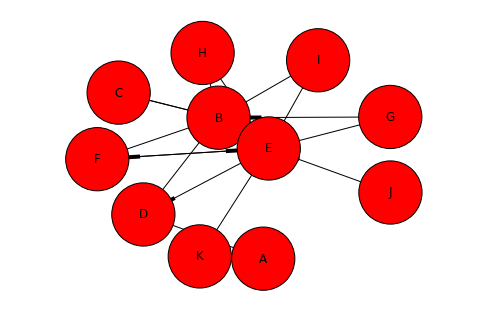

In [27]:
# Jump factor as 0
Graph_Generation('HW_9_2_0_0', 4000)

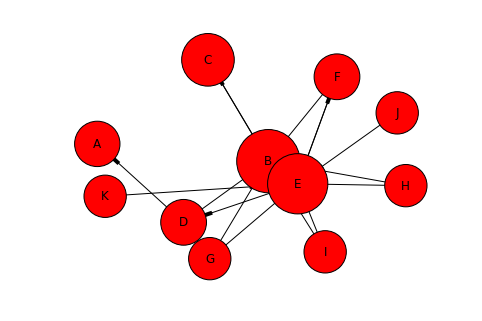

In [29]:
# Jump factor as 0.25
Graph_Generation('HW_9_2_0_25', 4000)

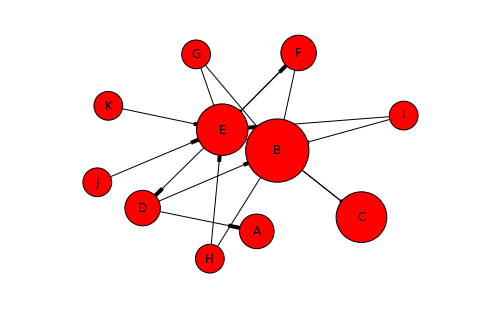

In [31]:
# Jump factor as 0.5
Graph_Generation('HW_9_2_0_5', 4000)

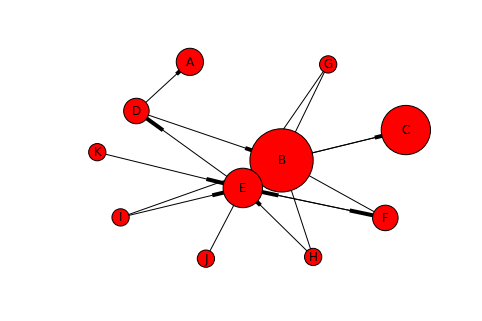

In [33]:
# Jump factor as 0.75
Graph_Generation('HW_9_2_0_75', 4000)

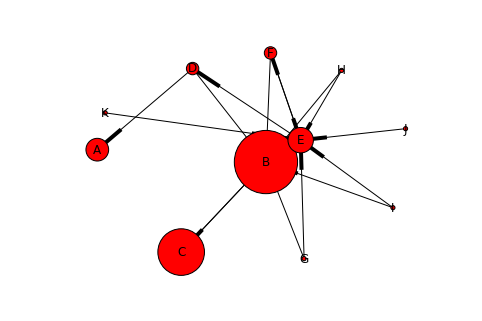

In [37]:
# Jump factor as 1.0
Graph_Generation('HW_9_2_1_0', 4000)

## HW 9.2 Analysis
### When jump factor becomes larger, the trend of mass concentration becomes more significant. 

# HW 9.3: Applying PageRank to the Wikipedia hyperlinks network 

## HW 9.3 Implementation

In [12]:
!hdfs dfs -mkdir -p /user/shihyu
!hdfs dfs -put all-pages-indexed-out.txt /user/shihyu 
!hdfs dfs -put indices_WIKIiki.txt /user/shihyu 

put: `/user/shihyu/all-pages-indexed-out.txt': File exists
put: `/user/shihyu/indices_wiki.txt': File exists


In [19]:
#!python RunPageRank.py -g 'hdfs:///user/shihyu/all-pages-indexed-out.txt' -j 0.15 -i 1 -d 'hdfs:///user/shihyu/indices_WIKIiki.txt' -s '0'
#!hdfs dfs -cat /user/shihyu/join/p* > wiki_5iter_top100
!head -100 wiki_5iter_top100

0.0014614491942438349	"13455888 - United States"
0.0006663317375798755	"1184351 - Animal"
0.0006398051875506791	"4695850 - France"
0.0005748538826286757	"5051368 - Germany"
0.0004503047142785041	"1384888 - Arthropod"
0.00044660099098876925	"2437837 - Canada"
0.0004448182480165896	"6113490 - Insect"
0.000444203734598283	"7902219 - List of sovereign states"
0.0004329952449265189	"13425865 - United Kingdom"
0.000427885336130834	"6076759 - India"
0.00042327595490625425	"4196067 - England"
0.00039817029586927596	"6172466 - Iran"
0.0003854336708092153	"14112583 - World War II"
0.0003631670660462813	"10390714 - Poland"
0.00034383110763123157	"15164193 - village"
0.0003383478652193903	"3191491 - Countries of the world"
0.0003293524626579213	"6416278 - Japan"
0.00032896996556415974	"6237129 - Italy"
0.00032632071986423984	"7835160 - List of countries"
0.0003250758881557822	"1516699 - Australia"
0.0003131434418030617	"13725487 - Voivodeships of Poland"
0.0003095941242456258	"9276255 - National R

In [20]:
#!python RunPageRank.py -g 'hdfs:///user/shihyu/all-pages-indexed-out.txt' -j 0.15 -i 10 \
#-d 'hdfs:///user/shihyu/indices_WIKIiki.txt' -s '0'
#!hdfs dfs -cat /user/shihyu/join/p* > wiki_10iter_top100
!head -100 wiki_10iter_top100

0.0014615599816380814	"13455888 - United States"
0.0006660177936038597	"1184351 - Animal"
0.0006396773757180422	"4695850 - France"
0.0005747671982893716	"5051368 - Germany"
0.0004501232221973807	"1384888 - Arthropod"
0.00044667005168115624	"2437837 - Canada"
0.00044463224402460465	"6113490 - Insect"
0.00044387869965694206	"7902219 - List of sovereign states"
0.00043314218173262273	"13425865 - United Kingdom"
0.00042770776770628867	"6076759 - India"
0.00042341679596246464	"4196067 - England"
0.000397826042012343	"6172466 - Iran"
0.00038548623796188223	"14112583 - World War II"
0.00036266653367941786	"10390714 - Poland"
0.00034358745300642004	"15164193 - village"
0.0003380496128621886	"3191491 - Countries of the world"
0.0003292203268728178	"6416278 - Japan"
0.00032899474579557773	"6237129 - Italy"
0.00032620175381522067	"7835160 - List of countries"
0.00032511085571704744	"1516699 - Australia"
0.00031268227722189133	"13725487 - Voivodeships of Poland"
0.0003095692741012243	"9276255 - Na

## HW 9.3 Analysis

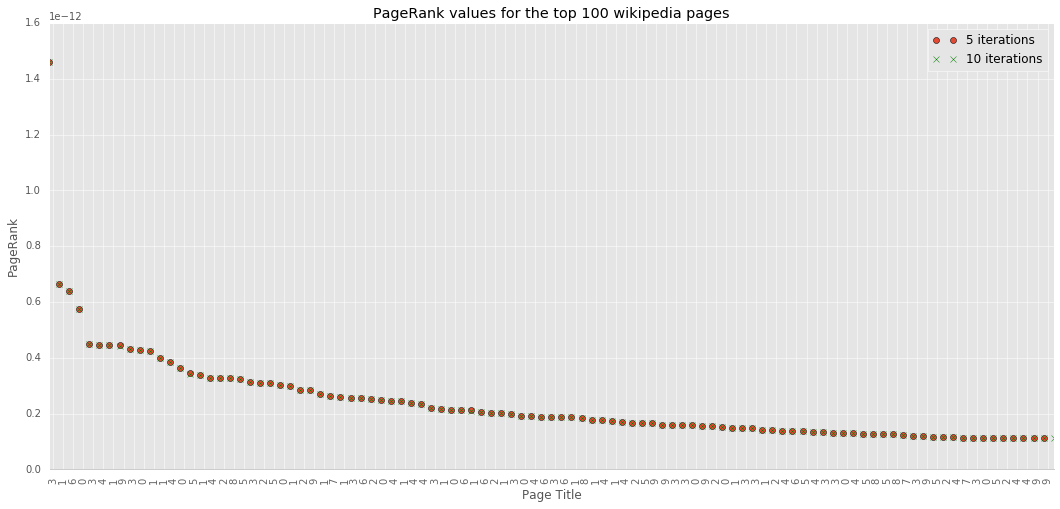

In [48]:
%matplotlib inline
from __future__ import division
import numpy as np
import pylab as pl
import itertools
from random import shuffle

data5 = []
data10 = []
A5 = {}
A10 = {}

for line in open("wiki_5iter_top100").readlines():
    line = line.strip()
    score, value = line.split('\t')
    value = json.loads(value)
    Y = float(score)/1000000000
    X = value[1]
    data5.append([X,Y])
    A5[X] = Y
    
for line in open("wiki_10iter_top100").readlines():
    line = line.strip()
    score, value = line.split('\t')
    value = json.loads(value)
    Y = float(score)/1000000000
    X = value[1]
    data10.append([X,Y])
    A10[X] = Y

#join the 10 iteration results with the 5 iteration results:    
for item in data5:
    key = item[0]
    score = A10.get(key) or 0
    data10.append([ key, score ])
    

items10 = (np.array(data10).T)  
items5 = (np.array(data5).T)

fig = pl.figure(figsize=(18,8))
ax = pl.subplot(111)
width=0.8
ax.set_xticks(np.arange(len(items5[0])) + width/2)
ax.set_xticklabels(items5[0], rotation=90, color="#666666")

ax.plot(items5[1],'o', label='5 iterations')
ax.plot(items10[1],'x', c='green', label='10 iterations')


pl.tick_params(
            axis='both', 
            which='both',
            bottom='off',
            left='off',
            top='off',
            right='off'
)

ax.spines['bottom'].set_color('#cccccc')
pl.legend()
pl.xlim([0, 100])
pl.ylabel("PageRank")
pl.xlabel("Page Title")
pl.title("PageRank values for the top 100 wikipedia pages")
pl.show()

# HW 9.4: Topic-specific PageRank implementation using MRJob

In [10]:
%%writefile PageRankIter_Topic.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankIter_Topic(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankIter_Topic, self).configure_options()        
        self.add_passthrough_option(
            '--i', dest='init', default='0', type='int',
            help='i: run initialization iteration (default 0)') 
        self.add_passthrough_option(
            '--n', dest='n_topic', default='0', type='int',
            help='n: number of topics (default 0)') 

    def mapper_job_init(self, _, line):        
        # parse line
        node_id, adj_list = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'adj_list = %s' %adj_list
        exec cmd
        # initialize node struct        
        node = {'a':adj_list.keys(), 'M':[0]*(self.options.n_topic + 1)}
        # maintain an array of ranks for each topic
        rankMass = [1.0 / len(adj_list)] * (self.options.n_topic + 1)
   
        yield node_id, node
     
        for m in node['a']:
            yield m, rankMass
            
    def mapper_job_iter(self, _, line):             
        # parse line
        node_id, node = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # map rank mass  
        n_adj = len(node['a'])
        if n_adj > 0:
            rankMass = [x / n_adj for x in node['M']]
          
            for m in node['a']:
                yield m, rankMass
        else:
          
            for i in range(self.options.n_topic+1):
                self.increment_counter('dangling_mass', 'topic_%d' %i, int(node['M'][i]*1e10))
       
        node['M'] = [0]*(self.options.n_topic+1)
        yield node_id, node
    
    def debug(self):
        de = 'bug'
                
   
    def combiner(self, node_id, value):             
        rankMass, node = [0]*(self.options.n_topic+1), None        
        # loop through all arrivals
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]                
            else:
                node = v            
        # emit accumulative mass for node_id
        if node:
            node['M'] = [a+b for a,b in zip(rankMass, node['M'])]
            yield node_id, node
        else:
            yield node_id, rankMass
    
    # reducer for initialization pass --> need to handle dangling nodes
    def reducer_job_init(self, node_id, value):      
        # increase counter for node count
        self.increment_counter('node_count', 'nodes', 1)
        rankMass, node = [0]*(self.options.n_topic+1), None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]         
            else:
                node = v
        # handle dangling node, create node struct and add missing mass
        if not node:            
            node = {'a':[], 'M':rankMass}   
            for i in range(self.options.n_topic+1):
                self.increment_counter('dangling_mass', 'mass_%d' %i, int(1e10))
        else:
            node['M'] = [a+b for a,b in zip(rankMass, node['M'])]
        # emit for next iteration
        yield node_id, node
        
    # reducer for regular pass 
    def reducer_job_iter(self, node_id, value):              
        rankMass, node = [0]*(self.options.n_topic+1), None
     
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]        
            else:
                node = v
       
        node['M'] = [a+b for a,b in zip(rankMass, node['M'])]            
       
        yield node_id, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper_job_init if self.options.init else self.mapper_job_iter                       
                       , combiner=self.combiner                       
                       , reducer=self.reducer_job_init if self.options.init else self.reducer_job_iter
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankIter_Topic.run()

Overwriting PageRankIter_Topic.py


In [ ]:
#!python PageRankIter_Topic.py PageRank-test.txt --i 1 -r 'inline'  > iter9_4.t
#!cat iter9_4.t
!python PageRankIter_Topic.py randNet.txt --i 1 --n 10 -r 'inline' > test9_4_Iter.t
!cat test9_4_Iter.t

In [6]:
%%writefile PageRankDist_Topic.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankDist_Topic(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankDist_Topic, self).configure_options()        
        self.add_passthrough_option(
            '--s', dest='size', default=0, type='int',
            help='size: node number (default 0)')    
        self.add_passthrough_option(
            '--j', dest='alpha', default=0.15, type='float',
            help='jump: teleport factor (default 0.15)') 
        self.add_passthrough_option(
            '--b', dest='beta', default=0.99, type='float',
            help='beta: topic bias factor (default 0.99)') 
        self.add_passthrough_option(
            '--m', dest='m', default='', type='str',
            help='m: rank mass from dangling nodes') 
        self.add_passthrough_option(
            '--w', dest='wiki', default=0, type='int',
            help='w: if it is wiki data (default 1)') 
    
    def mapper_init(self):
        # load topic file and count
        T_j, self.T_index = {}, {}
        cat = Popen(['cat', 'randNet_topics.txt'], stdout=PIPE)
        for line in cat.stdout:
            nid, topic = line.strip().split('\t')
            self.T_index[nid] = topic
            T_j[topic] = 1 if topic not in T_j else (T_j[topic]+1)
            
        # prepare adjustment factors
        self.damping = 1 - self.options.alpha        
        cmd = 'm = %s' %self.options.m
        exec cmd
        # assuming here -m is specified with a list syntax string
        self.p_dangling = [1.0*x / self.options.size for x in m]
        # for each topic, get topic bias
        self.v_ij = [[1, 1]]*(len(T_j)+1)
        N, b = self.options.size, self.options.beta
        for t in T_j:
            self.v_ij[int(t)] = [(1-b)*N/(N-T_j[t]), b*N/T_j[t]]
                
            
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank        
        for i in range(len(self.v_ij)):
            vij = self.v_ij[i][i==int(self.T_index[nid])]
            node['M'][i] = (self.p_dangling[i]+node['M'][i])*self.damping + self.options.alpha*vij
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',           
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper                    
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankDist_Topic.run()


Writing PageRankDist_Topic.py


In [7]:
%%writefile PageRankSort_Topic.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankSort_Topic(MRJob):
    DEFAULT_PROTOCOL = 'json'
    PARTITIONER = 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
    
    def mapper_init(self):
        # load topic file and count
        self.T_index = {}
        cat = Popen(['cat', 'randNet_topics.txt'], stdout=PIPE)
        for line in cat.stdout:
            nid, topic = line.strip().split('\t')
            self.T_index[nid] = topic                
            
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # emit (vector_ID, pageRank)~topic_id
        for i in range(len(node['M'])):
            yield (i, node['M'][i]), self.T_index[nid]
        
    def reducer_init(self):
        self.current_v = None
        self.i = 0
        self.top = 10
    
    def reducer(self, key, value):
        if self.current_v != key[0]:
            self.current_v = key[0]
            self.i = 0
            yield '====== Top 10 for topic %d ======' %self.current_v, ''
        if self.i < self.top:
            self.i += 1
            for v in value:
                yield key, v
        
    
    def steps(self):
        jc = {
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '3',            
            'mapreduce.partition.keypartitioner.options': '-k1,1',             
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2nr',            
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',   
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper     
                       , reducer_init=self.reducer_init
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankSort_Topic.run()



Writing PageRankSort_Topic.py


In [35]:
!python PageRankSort_Topic.py  test9_4_Dist --file 'randNet_topics.txt'  -r 'inline' > test9_4_Sort
!cat test9_4_Sort

Using configs in /etc/mrjob.conf
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/PageRankSort_T.cloudera.20161030.031950.765807
Running step 1 of 1...
Streaming final output from /tmp/PageRankSort_T.cloudera.20161030.031950.765807/output...
Removing temp directory /tmp/PageRankSort_T.cloudera.20161030.031950.765807...
"====== Top 10 for topic 6 ======"	""
[6, 0.7406390902241966]	"3"
[6, 0.7529258312609377]	"5"
[6, 0.7538245159096223]	"1"
[6, 0.7623089481440546]	"3"
[6, 0.7628491024342088]	"1"
[6, 0.7819031039882105]	"1"
[6, 0.7930033925884991]	"5"
[6, 0.7970816754167818]	"8"
[6, 0.8153266249117314]	"9"
[6, 0.8314251097602162]	"10"
"====== Top 10 for topic 7 ======"	""
[7, 0.31711111111111107]	"3"
[7, 0.35351845376845376]	"2"
[7, 0.3936573426573426]	"6"
[7, 0.39930891330891327]	"1"
[7, 0.4115555555555555]	"4"
[7, 0.42158025308025304]	"1"
[7, 0.42780735930735925]	"9"
[7, 0.5100782828282828]	"8"


In [8]:
%%writefile RunPageRank_Topic.py
#!/usr/bin/python

from PageRankIter_Topic import PageRankIter_Topic
from PageRankDist_Topic import PageRankDist_Topic
from PageRankSort_Topic import PageRankSort_Topic
from PageRankJoin import PageRankJoin
from helper import getCounter, getCounters
from subprocess import call, check_output
from time import time
import sys, getopt, datetime, os

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "g:j:i:d:s:")
    except getopt.GetoptError:
        print 'Wrong arguments format'
        sys.exit(2)
    if len(opts) != 5:
        print 'Wrong arguments number'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-g':
            graph = arg
        elif opt == '-j':
            jump = arg
        elif opt == '-i':            
            n_iter = arg
        elif opt == '-d':
            index = arg
        elif opt == '-s':
            n_node = arg
        
start = time()
FNULL = open(os.devnull, 'w')
n_iter = int(n_iter)
doJoin = index!='NULL'
doInit = n_node=='0'
host = 'localhost'

print '%s: %s topic sensitive PageRanking on \'%s\' for %d iterations with damping factor %.2f ...' %(str(datetime.datetime.now()),
          'start' if doInit else 'continue', graph[graph.rfind('/')+1:], n_iter, 1-float(jump))

if doInit:
    # clear directory
    print str(datetime.datetime.now()) + ': clearing directory ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/out'], stdout=FNULL)
    
    # creat initialization job    
    init_job = PageRankIter_Topic(args=[graph, '--i', '1', '--n', '11', '-r', 'hadoop', 
                                    '--output-dir', 'hdfs:///user/shihyu/out'])

    # run initialization job
    print str(datetime.datetime.now()) + ': running iteration 1 ...'
    with init_job.make_runner() as runner:    
        runner.run()

    # checking counters
    n_node = getCounter('node_count', 'nodes', host)    
    loss = getCounters('dangling_mass', host)
    loss_array = ['0']*11
    for k in loss:
        i = int(k.split('_')[1])
        loss_array[i] = str(loss[k]/1e10)
    print '%s: initialization complete: %d nodes!' %(str(datetime.datetime.now()), n_node)

    # run redistribution job
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])
    loss_param = '[%s]' %(','.join(['0']*11) if len(loss)==0 else ','.join(loss_array))
    dist_job = PageRankDist_Topic(args=['hdfs:///user/shihyu/in/part*', '--s', str(n_node), '--m', loss_param,
                                    '--file', 'hdfs:///user/shihyu/randNet_topics.txt',
                                    '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()

# move results for next iteration
call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])

# create iteration job
iter_job = PageRankIter_Topic(args=['hdfs:///user/shihyu/in/part*', '--i', '0', '--n', '11',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])

# run pageRank iteratively
i = 2 if doInit else 1
while(1):
    print str(datetime.datetime.now()) + ': running iteration %d ...' %i
    with iter_job.make_runner() as runner:        
        runner.run()
    
    # check counters for topic loss mass
    loss = getCounters('dangling_mass', host)
    loss_array = ['0']*11
    for k in loss:
        i = int(k.split('_')[1])
        loss_array[i] = str(loss[k]/1e10)
    
    # move results for next iteration
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])
        
    # run redistribution job
    loss_param = '[%s]' %(','.join(['0']*11) if len(loss)==0 else ','.join(loss_array))
    dist_job = PageRankDist_Topic(args=['hdfs:///user/shihyu/in/part*', '--s', str(n_node), '--m', loss_param,
                                    '--file', 'hdfs:///user/shihyu/randNet_topics.txt',
                                    '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])
    
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()
    
    if i == n_iter:
        break
    
    # if more iteration needed
    i += 1    
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'], stdout=FNULL)

# run sort job
print str(datetime.datetime.now()) + ': sorting PageRank ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/rank'], stdout=FNULL)
sort_job = PageRankSort_Topic(args=['hdfs:///user/shihyu/out/part*', '--file', 'hdfs:///user/shihyu/randNet_topics.txt',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/rank'])

with sort_job.make_runner() as runner:    
    runner.run()
    
# run join job
if doJoin:
    print str(datetime.datetime.now()) + ': joining PageRank with index ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/join'], stdout=FNULL)
    join_job = PageRankJoin(args=[index, '-r', 'hadoop', '--file', 'hdfs:///user/shihyu/rank/part-00000', 
                                  '--output-dir', 'hdfs:///user/shihyu/join'])
    with join_job.make_runner() as runner:
        runner.run()

print "%s: PageRank job completes in %.1f secs!\n" %(str(datetime.datetime.now()), (time()-start))


call(['hdfs', 'dfs', '-cat', '/user/shihyu/join/p*' if doJoin else '/user/shihyu/rank/p*'])


Writing RunPageRank_Topic.py


In [82]:
!hdfs dfs -mkdir -p /user/shihyu
!hdfs dfs -put randNet.txt /user/shihyu 
!hdfs dfs -put randNet_topics.txt /user/shihyu 

put: `/user/shihyu/randNet.txt': File exists
put: `/user/shihyu/randNet_topics.txt': File exists


In [36]:
!python RunPageRank_Topic.py -g 'hdfs:///user/shihyu/randNet.txt' -j 0.15 -i 2 -d 'NULL' -s '0'

2016-10-29 21:00:25.108449: start topic sensitive PageRanking on 'randNet.txt' for 2 iterations with damping factor 0.85 ...
2016-10-29 21:00:25.108525: clearing directory ...
rm: `/user/shihyu/in': No such file or directory
2016-10-29 21:00:30.810053: running iteration 1 ...
2016-10-29 21:01:15.383313: initialization complete: 100 nodes!
2016-10-29 21:01:18.280948: distributing loss mass ...
2016-10-29 21:01:55.741874: running iteration 2 ...
2016-10-29 21:02:42.406198: distributing loss mass ...
No handlers could be found for logger "mrjob.hadoop"
2016-10-29 21:03:14.427037: sorting PageRank ...
2016-10-29 21:04:10.459586: PageRank job completes in 225.4 secs!

"====== Top 10 for topic 0 ======"	""
[0, 1.6076271109890086]	"4"
[0, 1.5757123883143969]	"3"
[0, 1.5742073671113035]	"10"
[0, 1.540390989068374]	"2"
[0, 1.5221086826843588]	"8"
[0, 1.4912908154538556]	"7"
[0, 1.451330386178526]	"1"
[0, 1.4330922286519523]	"2"
[0, 1.4282327277192604]	"2"
[0, 1.420359996116097]	"8"
"====== Top 

## HW 9.4 Analysis

# HW 9.5: (OPTIONAL) Applying topic-specific PageRank to Wikipedia

## HW 9.5 Implementation

In [37]:
# Get weights of each topics
topic_index = [0]*10
with open('indices_Wiki.txt') as f:
    for line in f.readlines():        
        name = line.split('\t')[0]        
        topic_index[len(name)%10] += 1

print topic_index

[1455304, 1536145, 1591290, 1624124, 1610195, 1550659, 1511681, 1472178, 1419076, 1421625]


In [6]:
# Prepare a text file for node id and its associated topic, later used to ranking
text_file = open("nid_topic_Wiki.txt", "w")
counter = 0
with open('indices_Wiki.txt') as f:
    for line in f.readlines():    
        if counter < 9223372036854775807:
            name = line.split('\t')[0]
            node_id = line.split('\t')[1]
            topic_index = len(name)%10
            text_file.write("%s\t%s\n"%(node_id, topic_index))
        else:
            break
        counter = counter + 1
    text_file.close()

!head -20 nid_topic_Wiki.txt

1	1
2	4
3	9
4	8
5	3
6	1
7	0
8	9
9	7
10	1
11	5
12	3
13	8
14	8
15	4
16	2
17	8
18	2
19	3
20	1


In [5]:
%%writefile PageRankIter_WIKI.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class PageRankIter_WIKI(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankIter_WIKI, self).configure_options()        
        self.add_passthrough_option(
            '--i', dest='init', default='0', type='int',
            help='i: run initialization iteration (default 0)') 
        self.add_passthrough_option(
            '--n', dest='n_topic', default='0', type='int',
            help='n: number of topics (default 0)') 

    def mapper_job_init(self, _, line):        
        # parse line
        node_id, adj_list = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'adj_list = %s' %adj_list
        exec cmd
        # initialize node struct        
        node = {'a':adj_list.keys(), 'M':[0]*(self.options.n_topic + 1)}
        # maintain an array of ranks for each topic
        rankMass = [1.0 / len(adj_list)] * (self.options.n_topic + 1)
   
        yield node_id, node
     
        for m in node['a']:
            yield m, rankMass
            
    def mapper_job_iter(self, _, line):             
        # parse line
        node_id, node = line.strip().split('\t', 1)
        node_id = node_id.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # map rank mass  
        n_adj = len(node['a'])
        if n_adj > 0:
            rankMass = [x / n_adj for x in node['M']]
          
            for m in node['a']:
                yield m, rankMass
        else:
          
            for i in range(self.options.n_topic+1):
                self.increment_counter('dangling_mass', 'topic_%d' %i, int(node['M'][i]*1e10))
       
        node['M'] = [0]*(self.options.n_topic+1)
        yield node_id, node
    
    def debug(self):
        de = 'bug'
                
   
    def combiner(self, node_id, value):             
        rankMass, node = [0]*(self.options.n_topic+1), None        
        # loop through all arrivals
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]                
            else:
                node = v            
        # emit accumulative mass for node_id
        if node:
            node['M'] = [a+b for a,b in zip(rankMass, node['M'])]
            yield node_id, node
        else:
            yield node_id, rankMass
    
    # reducer for initialization pass --> need to handle dangling nodes
    def reducer_job_init(self, node_id, value):      
        # increase counter for node count
        self.increment_counter('node_count', 'nodes', 1)
        rankMass, node = [0]*(self.options.n_topic+1), None
        # loop through all arrivals
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]         
            else:
                node = v
        # handle dangling node, create node struct and add missing mass
        if not node:            
            node = {'a':[], 'M':rankMass}   
            for i in range(self.options.n_topic+1):
                self.increment_counter('dangling_mass', 'mass_%d' %i, int(1e10))
        else:
            node['M'] = [a+b for a,b in zip(rankMass, node['M'])]
        # emit for next iteration
        yield node_id, node
        
    # reducer for regular pass 
    def reducer_job_iter(self, node_id, value):              
        rankMass, node = [0]*(self.options.n_topic+1), None
     
        for v in value:            
            if isinstance(v, list):
                rankMass = [a+b for a,b in zip(rankMass, v)]        
            else:
                node = v
       
        node['M'] = [a+b for a,b in zip(rankMass, node['M'])]            
       
        yield node_id, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '2',
        }
        return [MRStep(mapper=self.mapper_job_init if self.options.init else self.mapper_job_iter                       
                       , combiner=self.combiner                       
                       , reducer=self.reducer_job_init if self.options.init else self.reducer_job_iter
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankIter_WIKI.run()

Writing PageRankIter_WIKI.py


In [9]:
!python PageRankIter_WIKI.py wiki_sample --i 1 --n 10 -r 'inline' > test9_5_Iter.txt
!cat test9_5_Iter.txt

Usage: PageRankIter_W.py [options] [input files]

PageRankIter_W.py: error: no such option: -i


In [4]:
%%writefile PageRankDist_WIKI.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankDist_WIKI(MRJob):
    DEFAULT_PROTOCOL = 'json'

    def configure_options(self):
        super(PageRankDist_WIKI, self).configure_options()        
        self.add_passthrough_option(
            '--s', dest='size', default=0, type='int',
            help='size: node number (default 0)')    
        self.add_passthrough_option(
            '--j', dest='alpha', default=0.15, type='float',
            help='jump: teleport factor (default 0.15)') 
        self.add_passthrough_option(
            '--b', dest='beta', default=0.99, type='float',
            help='beta: topic bias factor (default 0.99)') 
        self.add_passthrough_option(
            '--m', dest='m', default='', type='str',
            help='m: rank mass from dangling nodes') 
        self.add_passthrough_option(
            '--w', dest='wiki', default=0, type='int',
            help='w: if it is wiki data (default 1)') 
            
    def mapper_init(self):
        self.T_index = {}
        cat = Popen(['cat', 'nid_topic_WIKIiki.txt'], stdout=PIPE)
        for line in cat.stdout:
            nid, topic = line.strip().split('\t')
            self.T_index[nid] = topic
            
        # load topic file and count
        T_j = [1455304, 1536145, 1591290, 1624124, 1610195, 1550659, 1511681, 1472178, 1419076, 1421625]     
        N = sum(T_j)
        # prepare adjustment factors
        self.damping = 1 - self.options.alpha        
        cmd = 'm = %s' %self.options.m
        exec cmd
        # assuming here -m is specified with a list syntax string
        self.p_dangling = [1.0*x / N for x in m]
        # for each topic, get topic bias
        b = self.options.beta
        self.v_ij = [[1, 1]] + [[(1-b)*N/(N-t), b*N/t] for t in T_j]
                    
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # get final pageRank        
        for i in range(len(self.v_ij)):
            vij = self.v_ij[i][i==int(self.T_index[nid])]
            node['M'][i] = (self.p_dangling[i]+node['M'][i])*self.damping + self.options.alpha*vij
        yield nid, node

    def steps(self):
        jc = {
            'mapreduce.job.maps': '2',           
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper                    
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankDist_WIKI.run()


Writing PageRankDist_WIKI.py


In [2]:
##### unit test 9_5_Dist ##### 
!hadoop fs -rm -r /user/shihyu/out
!python PageRankDist_WIKI.py  test9_5_Iter.txt --m '[1]*11' --s '32161' --file 'nid_topic_WIKIiki.txt'  -r 'hadoop' --output-dir 'hdfs:///user/shihyu/out'
#head test9_5_Dist

Deleted /user/shihyu/out
No configs found; falling back on auto-configuration
Creating temp directory /tmp/PageRankDist_W.cloudera.20161031.070726.015103
Looking for hadoop binary in $PATH...
Found hadoop binary: /usr/bin/hadoop
Using Hadoop version 2.6.0
Copying local files to hdfs:///user/cloudera/tmp/mrjob/PageRankDist_W.cloudera.20161031.070726.015103/files/...
Looking for Hadoop streaming jar in /home/hadoop/contrib...
Looking for Hadoop streaming jar in /usr/lib/hadoop-mapreduce...
Found Hadoop streaming jar: /usr/lib/hadoop-mapreduce/hadoop-streaming.jar
Running step 1 of 1...
  packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.8.0.jar] /tmp/streamjob915005252337131852.jar tmpDir=null
  Connecting to ResourceManager at /0.0.0.0:8032
  Connecting to ResourceManager at /0.0.0.0:8032
  Total input paths to process : 1
  number of splits:2
  Submitting tokens for job: job_1477897418622_0001
  Submitted application application_1477897418622_0001
  The url to tr

In [3]:
%%writefile PageRankSort_WIKI.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from subprocess import Popen, PIPE

class PageRankSort_WIKI(MRJob):
    DEFAULT_PROTOCOL = 'json'
    PARTITIONER = 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
    
    def mapper_init(self):
        # load topic file and count
        self.T_index = {}
        cat = Popen(['cat', 'nid_topic_WIKIiki.txt'], stdout=PIPE)
        for line in cat.stdout:
            nid, topic = line.strip().split('\t')
            self.T_index[nid] = topic                
            
    def mapper(self, _, line):             
        # parse line
        nid, node = line.strip().split('\t', 1)
        nid = nid.strip('"')
        cmd = 'node = %s' %node
        exec cmd
        # emit (vector_ID, pageRank)~topic_id
        for i in range(len(node['M'])):
            yield (i, node['M'][i]), self.T_index[nid]
        
    def reducer_init(self):
        self.current_v = None
        self.i = 0
        self.top = 10
    
    def reducer(self, key, value):
        if self.current_v != key[0]:
            self.current_v = key[0]
            self.i = 0
            
            yield '====== Top 10 for topic %d ======' %self.current_v, ''
        if self.i < self.top:
            self.i += 1
            self.limit = 0
            for v in value:
                if self.limit < 1:
                    self.limit += 1
                    yield key, v
                else: 
                    break;
                    
    
    def steps(self):
        jc = {
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '3',            
            'mapreduce.partition.keypartitioner.options': '-k1,1',             
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k1,1 -k2,2nr',            
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',   
        }
        return [MRStep(mapper_init=self.mapper_init
                       , mapper=self.mapper     
                       , reducer_init=self.reducer_init
                       , reducer=self.reducer
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    PageRankSort_WIKI.run()




Writing PageRankSort_WIKI.py


In [7]:
##### unit test 9_5_Sort #####
!python PageRankSort_WIKI.py test9_5_Dist --file 'nid_topic_WIKIiki.txt'  -r 'inline' > test9_5_Sort
!cat test9_5_Sort

Using configs in /etc/mrjob.conf
ignoring partitioner keyword arg (requires real Hadoop): 'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
Creating temp directory /tmp/PageRankSort_W.cloudera.20161030.180134.525453
Running step 1 of 1...
Streaming final output from /tmp/PageRankSort_W.cloudera.20161030.180134.525453/output...
Removing temp directory /tmp/PageRankSort_W.cloudera.20161030.180134.525453...
"====== Top 10 for topic 6 ======"	""
[6, 0.008627199265445548]	"5"
[6, 0.008637775854557774]	"0"
[6, 0.008706766262308567]	"3"
[6, 0.008717793456759163]	"1"
[6, 0.008729778135806636]	"5"
[6, 0.00874691741960663]	"9"
[6, 0.00875389607313701]	"0"
[6, 0.008787626231867168]	"3"
[6, 0.008828904398145335]	"1"
[6, 0.008873952570312149]	"0"
"====== Top 10 for topic 7 ======"	""
[7, 0.0016658032239409717]	"0"
[7, 0.002542091883734786]	"0"
[7, 0.002880088938226686]	"0"
[7, 0.003041207754685308]	"0"
[7, 0.0034781699616808436]	"0"
[7, 0.0037563775980205003]	"0"
[7, 0.0038678757628010756]	"0

In [2]:
%%writefile RunPageRank_WIKI.py
#!/usr/bin/python

from PageRankIter_WIKI import PageRankIter_WIKI
from PageRankDist_WIKI import PageRankDist_WIKI
from PageRankSort_WIKI import PageRankSort_WIKI
from PageRankJoin import PageRankJoin
from helper import getCounter, getCounters
from subprocess import call, check_output
from time import time
import sys, getopt, datetime, os

# parse parameter
if __name__ == "__main__":

    try:
        opts, args = getopt.getopt(sys.argv[1:], "g:j:i:d:s:")
    except getopt.GetoptError:
        print 'Wrong arguments format'
        sys.exit(2)
    if len(opts) != 5:
        print 'Wrong arguments number'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-g':
            graph = arg
        elif opt == '-j':
            jump = arg
        elif opt == '-i':            
            n_iter = arg
        elif opt == '-d':
            index = arg
        elif opt == '-s':
            n_node = arg
        
start = time()
FNULL = open(os.devnull, 'w')
n_iter = int(n_iter)
doJoin = index!='NULL'
doInit = n_node=='0'
host = 'localhost'

print '%s: %s topic sensitive PageRanking on \'%s\' for %d iterations with damping factor %.2f ...' %(str(datetime.datetime.now()),
          'start' if doInit else 'continue', graph[graph.rfind('/')+1:], n_iter, 1-float(jump))

if doInit:
    # clear directory
    print str(datetime.datetime.now()) + ': clearing directory ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/out'], stdout=FNULL)
    
    # creat initialization job    
    init_job = PageRankIter_WIKI(args=[graph, '--i', '1', '--n', '10', '-r', 'hadoop', 
                                    '--output-dir', 'hdfs:///user/shihyu/out'])

    # run initialization job
    print str(datetime.datetime.now()) + ': running iteration 1 ...'
    with init_job.make_runner() as runner:    
        runner.run()

    # checking counters
    n_node = getCounter('node_count', 'nodes', host)    
    loss = getCounters('dangling_mass', host)
    loss_array = ['0']*11
    for k in loss:
        i = int(k.split('_')[1])
        loss_array[i] = str(loss[k]/1e10)
    print '%s: initialization complete: %d nodes!' %(str(datetime.datetime.now()), n_node)

    # run redistribution job
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])
    loss_param = '[%s]' %(','.join(['0']*11) if len(loss)==0 else ','.join(loss_array))
    dist_job = PageRankDist_WIKI(args=['hdfs:///user/shihyu/in/part*', '--s', str(n_node), '--m', loss_param,
                                    '--file', 'hdfs:///user/shihyu/wiki_sample',
                                    '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()

# move results for next iteration
call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])

# create iteration job
iter_job = PageRankIter_WIKI(args=['hdfs:///user/shihyu/in/part*', '--i', '0', '--n', '10',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])

# run pageRank iteratively
i = 2 if doInit else 1
while(1):
    print str(datetime.datetime.now()) + ': running iteration %d ...' %i
    with iter_job.make_runner() as runner:        
        runner.run()
    
    # check counters for topic loss mass
    loss = getCounters('dangling_mass', host)
    loss_array = ['0']*11
    for k in loss:
        i = int(k.split('_')[1])
        loss_array[i] = str(loss[k]/1e10)
    
    # move results for next iteration
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'])
        
    # run redistribution job
    loss_param = '[%s]' %(','.join(['0']*11) if len(loss)==0 else ','.join(loss_array))
    dist_job = PageRankDist_WIKI(args=['hdfs:///user/shihyu/in/part*', '--s', str(n_node), '--m', loss_param,
                                    '--file', 'hdfs:///user/shihyu/wiki_sample',
                                    '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/out'])
    
    print str(datetime.datetime.now()) + ': distributing loss mass ...'
    with dist_job.make_runner() as runner:    
        runner.run()
    
    if i == n_iter:
        break
    
    # if more iteration needed
    i += 1    
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/in'], stdout=FNULL)
    call(['hdfs', 'dfs', '-mv', '/user/shihyu/out', '/user/shihyu/in'], stdout=FNULL)

# run sort job
print str(datetime.datetime.now()) + ': sorting PageRank ...'
call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/rank'], stdout=FNULL)
sort_job = PageRankSort_WIKI(args=['hdfs:///user/shihyu/out/part*', '--file', 'hdfs:///user/shihyu/wiki_sample',
                              '-r', 'hadoop', '--output-dir', 'hdfs:///user/shihyu/rank'])

with sort_job.make_runner() as runner:    
    runner.run()
    
# run join job
if doJoin:
    print str(datetime.datetime.now()) + ': joining PageRank with index ...'
    call(['hdfs', 'dfs', '-rm', '-r', '/user/shihyu/join'], stdout=FNULL)
    join_job = PageRankJoin(args=[index, '-r', 'hadoop', '--file', 'hdfs:///user/shihyu/rank/part-00000', 
                                  '--output-dir', 'hdfs:///user/shihyu/join'])
    with join_job.make_runner() as runner:
        runner.run()

print "%s: PageRank job completes in %.1f secs!\n" %(str(datetime.datetime.now()), (time()-start))


call(['hdfs', 'dfs', '-cat', '/user/shihyu/join/p*' if doJoin else '/user/shihyu/rank/p*'])

Writing RunPageRank_WIKI.py


## HW 9.5 Analysis

In [7]:
!hdfs dfs -mkdir -p /user/shihyu
!hdfs dfs -put all-pages-indexed-out.txt /user/shihyu # 
!hdfs dfs -put indices_WIKIiki.txt /user/shihyu 

put: `/user/shihyu/all-pages-indexed-out.txt': File exists
put: `/user/shihyu/indices_wiki.txt': File exists


In [22]:
!hdfs dfs -mkdir -p /user/shihyu
!hdfs dfs -put wiki_sample /user/shihyu # 
!hdfs dfs -put wiki_index_sample /user/shihyu 
!hdfs dfs -put nid_topic_WIKIiki.txt /user/shihyu 

put: `/user/shihyu/wiki_sample': File exists
put: `/user/shihyu/wiki_index_sample': File exists
put: `/user/shihyu/nid_topic_wiki.txt': File exists


In [1]:
#!python RunPageRank_WIKI.py -g 'hdfs:///user/shihyu/all-pages-indexed-out.txt'  -j 0.15 -i 2 -d 'NULL' -s '0'
! cat wiki_topic

"====== Top 10 for topic 7 ======"	""
[7, 18168.2859148241]	4
[7, 13311.059756407594]	7
[7, 10588.6805693981]	10
[7, 10189.495447501646]	7
[7, 9153.828542626043]	7
[7, 8180.532910231774]	8
[7, 7302.697713785382]	2
[7, 6898.382134812705]	6
[7, 6599.769135912638]	7
[7, 6410.850248318637]	8
"====== Top 10 for topic 3 ======"	""
[3, 18168.28592457402]	4
[3, 13309.569018403192]	7
[3, 10588.680579148015]	10
[3, 10188.004709497243]	7
[3, 9152.33780462164]	7
[3, 8180.53291998169]	8
[3, 7302.697723535298]	2
[3, 6898.382144562621]	6
[3, 6598.278397908237]	7
[3, 6410.850258068553]	8
"====== Top 10 for topic 10 ======"	""
[10, 18168.285903930606]	4
[10, 13309.568997759781]	7
[10, 10590.265857407618]	10
[10, 10188.004688853833]	7
[10, 9152.33778397823]	7
[10, 8180.532899338278]	8
[10, 7302.697702891886]	2
[10, 6898.382123919209]	6
[10, 6598.278377264825]	7
[10, 6410.850237425141]	8
"====== Top 10 for topic 8 ======"	""
[8, 18168.28591002807]	4
[8, 13309.569003857247]	7
[8, 10588.68056460207]	10
[8,

# HW 9.6: (OPTIONAL) TextRank

## HW 9.6 Implementation

## HW 9.6 Analysis